In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats

In [348]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }

In [349]:
class data_assessment(object):
    # parse basic statistical properties of data
    def __init__(self, filepath, reference_date: str, history:str):
        self.filepath = filepath
        self.df = pd.read_csv(self.filepath)
        self.df = self.df.set_index(pd.to_datetime(self.df['Date']))
        self.reference_date = pd.to_datetime(reference_date)
        self.history = pd.to_datetime(history)
        self.reference_value = self.df.loc[self.reference_date,'Close']
        self.df['Noramlized_Close'] = self.df['Close'].divide(self.reference_value)
        self.df['Diff'] = self.df['Close'].diff()
        self.df.dropna(inplace=True)
        
        
        
    @property
    def data_info(self):
        return self.df.info()
    
    @property
    def before_after(self):
        self.before = self.df[(pd.to_datetime(self.df.index) <= self.reference_date) & (pd.to_datetime(self.df.index) >= self.history)]
        self.after = self.df[pd.to_datetime(self.df.index) > self.reference_date]
    
        return self

In [350]:
data = data_assessment('../data/SPLK.csv','2020-03-16', '2019-10-15')
data.reference_date

Timestamp('2020-03-16 00:00:00')

Let's Plot All time Series and with March 1 as the vertical line to show COVID

Text(2020-03-16 00:00:00, 200, 'March 16, 2020')

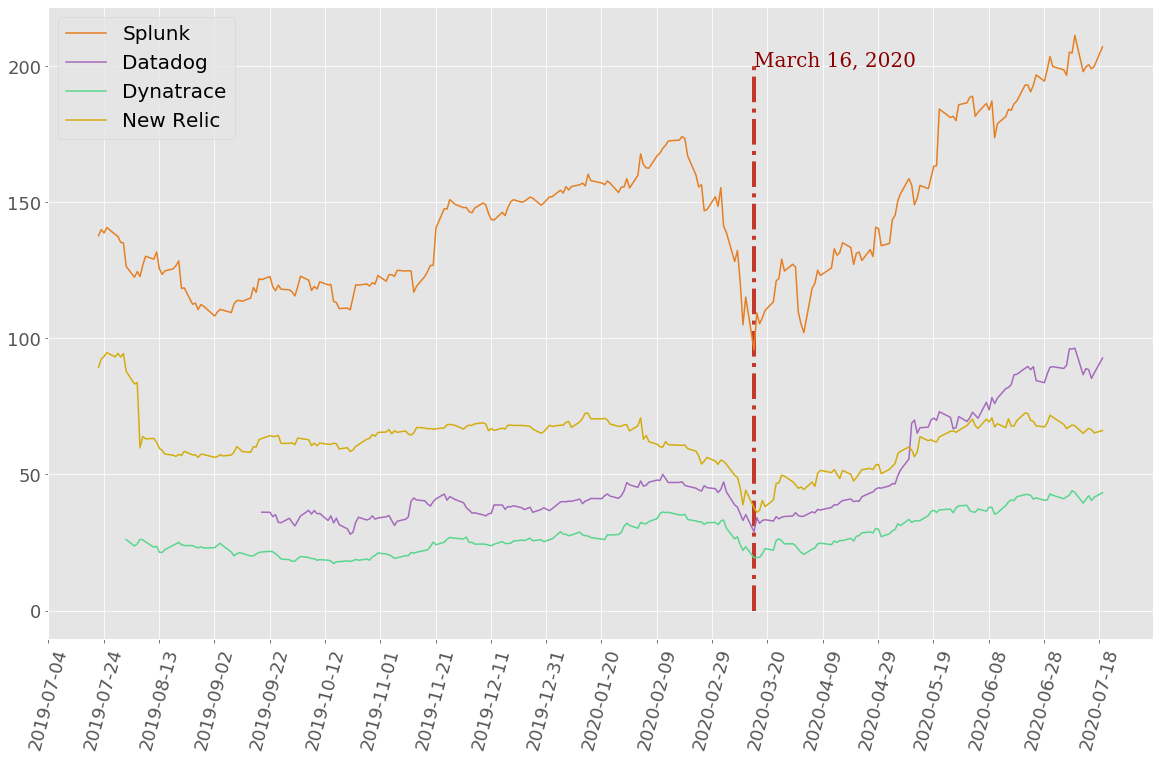

In [351]:
fig, ax = plt.subplots(figsize=(16, 10))
filepaths = ['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv']
APM_Companies = ['Splunk', 'Datadog', 'Dynatrace', 'New Relic']
colors = ['#E67E22', '#A569BD', '#58D68D', '#D4AC0D']
refer = dict(zip(filepaths, APM_Companies))

for filepath,color in zip(filepaths, colors):
    data = data_assessment(filepath, '2020-03-16', '2019-10-15')
    ax.plot(data.df.index, data.df['Close'], color=color, label=refer[filepath])

ax.vlines(data.reference_date, 0, 200, colors='#C0392B', linestyles='dashdot', linewidth=4)
ax.legend(loc='best', prop={'size': 20});
# ax.set_title('Daily Closing Stock Price ($) for Monitoring Companies', fontsize=24);
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 20));
ax.xaxis.set_tick_params(rotation=75)
fig.tight_layout()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
plt.text(data.reference_date, 200, r'March 16, 2020', fontdict=font)


#### Test Statistics
* Take difference shift(-1)
* Take 120 difference points after covid and 120 before covid
* Compute {mean, stardard deviation} of the before and after data
* Plot normal curves and run a p test

In [257]:
filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
before_after_dict = dict()
statistics = dict()

for filepath in filepaths:
    data = data_assessment(filepath, '2020-03-16', '2019-10-15').before_after
    before, after = data.before, data.after

    before_after_dict[filepath.split('/')[-1][:-4]] = {'before': before['Diff'],'after': after['Diff']}
    statistics[filepath.split('/')[-1][:-4]] = {'before': {'mean': round(before['Diff'].mean(),3), 'std': round(before['Diff'].std(), 3)},
                                                'after': {'mean': round(after['Diff'].mean(), 3), 'std': round(after['Diff'].std(), 3)},
                                              } 

In [259]:
pd.DataFrame(statistics)

,SPLK,DDOG,DT,NEWR
before,"{'mean': -0.228, 'std': 4.612}","{'mean': -0.039, 'std': 1.699}","{'mean': 0.008, 'std': 1.101}","{'mean': -0.222, 'std': 1.781}"
after,"{'mean': 1.28, 'std': 5.582}","{'mean': 0.733, 'std': 2.727}","{'mean': 0.275, 'std': 1.263}","{'mean': 0.326, 'std': 1.983}"


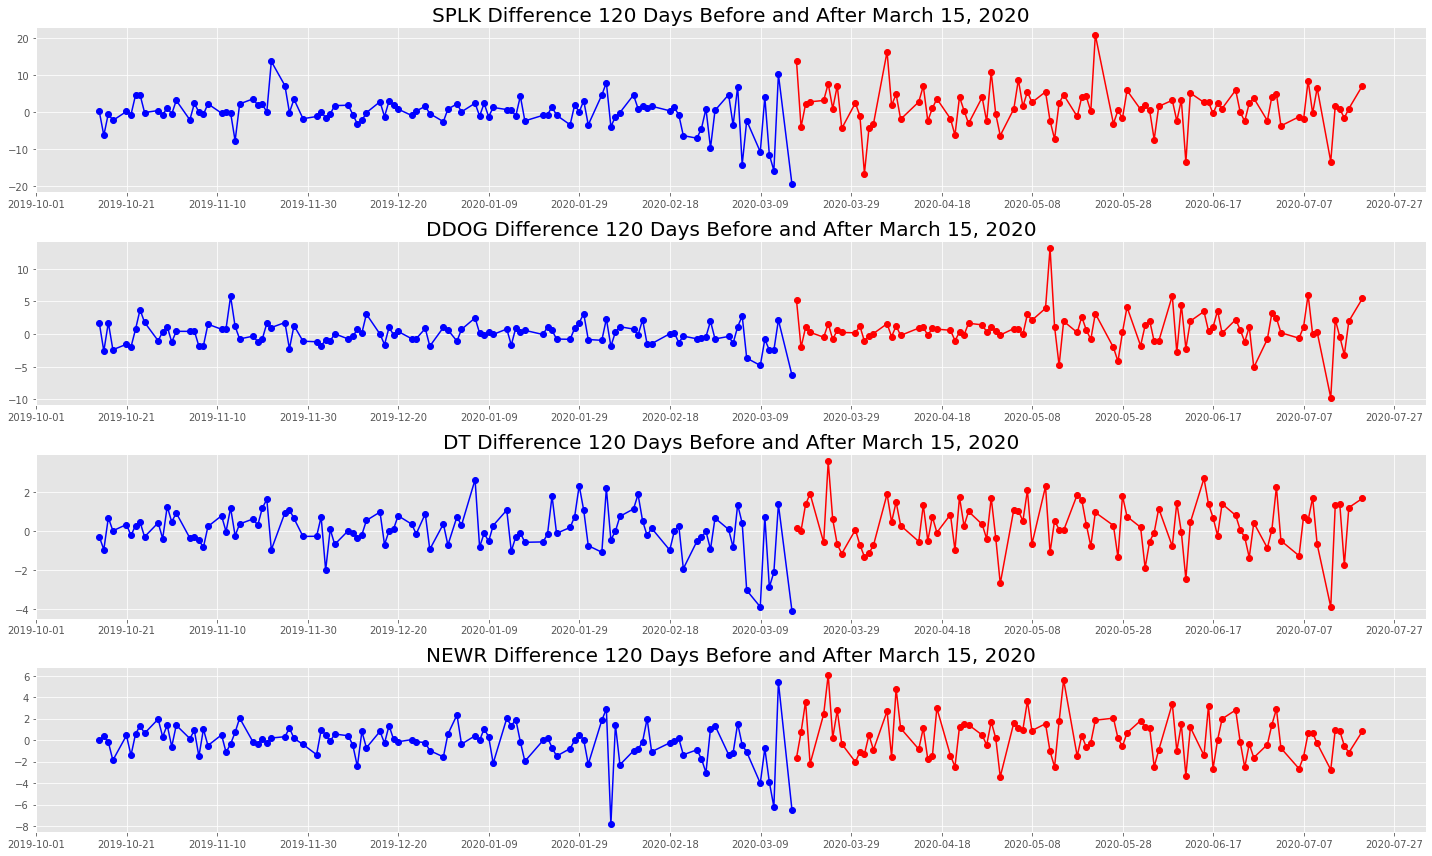

In [293]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12))

filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, '2020-03-16', '2019-10-15').before_after
    before, after = data.before, data.after
    ax.plot(before.index, before["Diff"], 'o-', color='b')
    ax.plot(after.index, after["Diff"], 'o-', color='r')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 20));
    ax.set_title(filepath.split('/')[-1][:-4] + ' Difference 120 Days Before and After March 15, 2020', fontsize=20);
    fig.tight_layout();

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

x = np.linspace(stats.norm.ppf(0.01, statistics['SPLK']['after']['mean'], statistics['SPLK']['after']['std']), stats.norm.ppf(0.99, statistics['SPLK']['after']['mean'], statistics['SPLK']['after']['std']), 100)
ax.plot(x, stats.norm.pdf(x, statistics['SPLK']['after']['mean'],  statistics['SPLK']['after']['std']), 'r-', lw=1, alpha=0.6, label='SPLK After')
x = np.linspace(stats.norm.ppf(0.01, statistics['SPLK']['before']['mean'], statistics['SPLK']['before']['std']), stats.norm.ppf(0.99, statistics['SPLK']['before']['mean'], statistics['SPLK']['before']['std']), 100)
# ax.plot(x, stats.norm.pdf(x, statistics['SPLK']['before']['mean'],  statistics['SPLK']['before']['std']), 'r-', lw=1, alpha=0.6, label='SPLK Before')
ax.set_xlim((-10, 10))
ax.legend()

##### Plot distributions before and after March 15, 2020

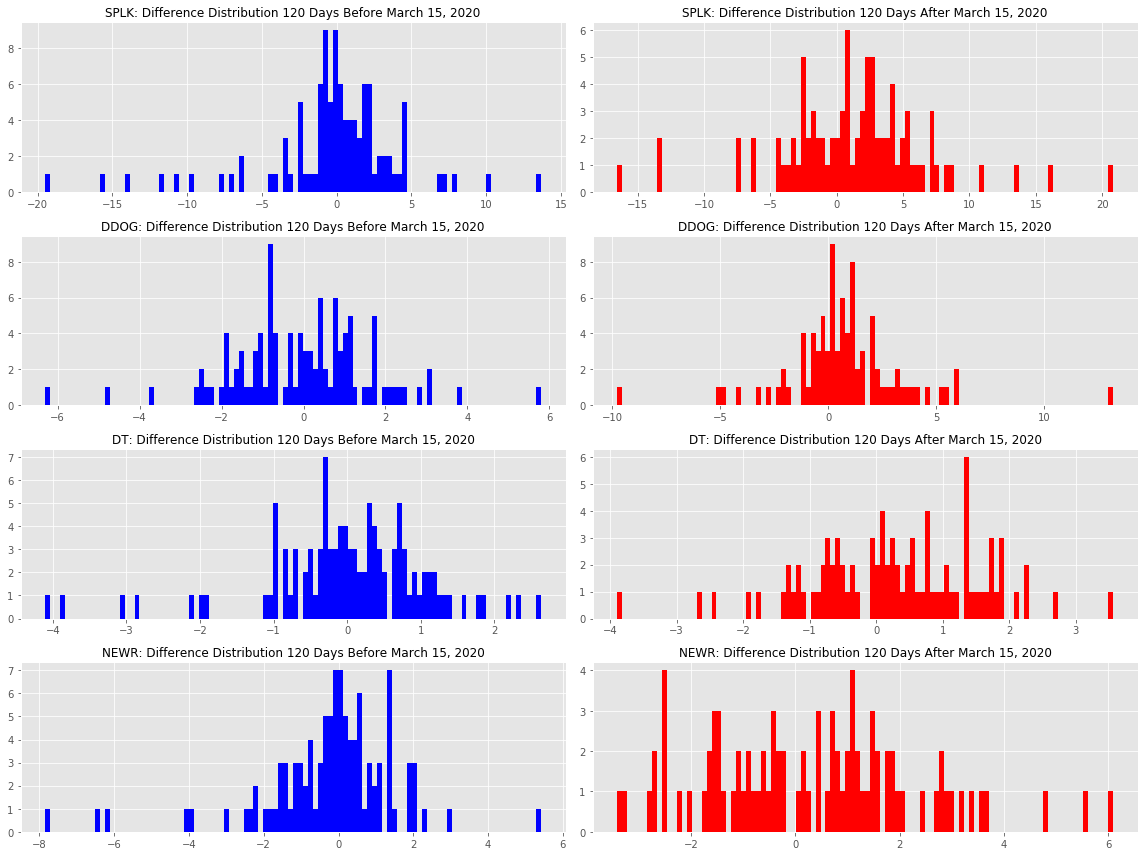

In [261]:
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
plots = axs.flatten()

filepaths = list(['../data/SPLK.csv', '../data/SPLK.csv', '../data/DDOG.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/DT.csv', '../data/NEWR.csv', '../data/NEWR.csv'])
    
for filepath, ax, c  in zip(filepaths, axs.flatten(), np.arange(8)):
    data = data_assessment(filepath, '2020-03-16', '2019-10-15').before_after
    before, after = data.before, data.after
    if c % 2:
        ax.hist(after["Diff"], bins=100, color='r')
        ax.set_title(filepath.split('/')[-1][:-4] + ': Difference Distribution 120 Days After March 15, 2020', fontsize=12)
    else:
        ax.hist(before["Diff"], bins=100, color='b')
        ax.set_title(filepath.split('/')[-1][:-4] + ': Difference Distribution 120 Days Before March 15, 2020', fontsize=12)
        
fig.tight_layout();

#### Run T-test on before and after data

In [264]:
filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
hyp_test = dict()
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, '2020-03-16', '2019-10-15').before_after
    before, after = data.before['Diff'], data.after['Diff']
    stat, p_val = stats.ttest_ind(before, after, axis=0, equal_var=False, nan_policy='omit')
    
    hyp_test[filepath.split('/')[-1][:-4]] = {'t_stat': stat, 'p_val': p_val}
    

In [265]:
pd.DataFrame(hyp_test)

,SPLK,DDOG,DT,NEWR
t_stat,-2.014599,-2.298923,-1.544077,-1.998822
p_val,0.045554,0.023007,0.124407,0.047177
